# Rocket Designer

In [1]:
import numpy as np

In [2]:
from matplotlib import pyplot as plt
from matplotlib import patches as mpathes

In [3]:
class Tank:
    # Fuel Tank
    def __init__(self,name):
        self.name = name
        self.dry_mass = 0 #dry mass, dead weight, kilogram
        self.capacity = 0 #capacity of fuel, liter
        self.fuel_type = None #Fuel type, object:fuel. i.e. LqdOxygen
        
    def mass(self):
        return self.dry_mass + (self.fuel_type.density) * (self.capacity)

class Fuel:
    # Fuel Resource
    def __init__(self,name):
        self.name = name
        self.density = 0 #Density of fuel, kilogram per meters cube
        self.color = (0,0,0) #color
        
class Engine:
    # Engine
    def __init__(self,name):
        self.name = name
        self.nozzle = 0 #Number of nozzle
        self.dry_mass = 0 #mass of engine, kilogram
        self.max_thrust = 0 #Max vacume thrust, newton
        self.Isp_surface  = 0 #Isp on surface, second
        self.Isp_vacume = 0 #Isp on vacume, second
    
    def set_resource(self,types,ratio):
        self.fuel_types = types #Resource type required, object:Fuel
        self.fuel_ratio = ratio #Resource ratio required
        
        assert len(self.fuel_ratio) == len(self.fuel_types) and abs(np.sum(self.fuel_ratio)-1) < 1e-5, "Resource Ratio Error"
        
    def mass(self):
        return self.dry_mass

class Stage:
    # Stage
    def __init__(self,name):
        self.name = name
        self.dead_weight = 0 #weight of shell, instruments and everything other than tanks and engines
        self.diameter = 0 # Diameter, meter
        self.height = 0 # Height, meter
        self.tanks = []
        self.engines = []
    
    def add_tank(self,tank):
        self.tanks.append(tank)
        assert np.pi*(self.diameter/2)**2*self.height > np.sum([i.capacity for i in self.tanks]), "Volumn of tanks exceeds stage capacity"
    def add_engine(self,engine):
        self.engines.append(engine)
    
    def mass(self):
        return self.dead_weight + np.sum([i.mass() for i in self.tanks]) + np.sum([i.mass() for i in self.engines])
    
class Fairing(Stage):
    # Fairing
    def __init__(self,name):
        Stage.__init__(self,name)
        self.curve = 0.7

class Rocket:
    # Rocket
    def _dv(isp,dry,wet):
        assert wet >= dry
        return isp*9.8*np.log(wet/dry)
    
    def __init__(self,name):
        self.name = name
        self.cores = [] #core stages, orders matter! index 0 = core stage at bottom, index 1 = second stage...
        self.sides = [] #side boosters
    
    def add_core(self,core:Stage):
        self.cores.append(core)
    
    def add_side(self,side:Stage):
        self.sides.append(side)
    
    def mass(self):
        return np.sum([i.mass() for i in self.cores]) + np.sum([i.mass() for i in self.sides])
    
    def dv(self):
        # DV for stages
        res = dict()
        n = len(self.cores)
        cores = self.cores[:]
        for i in range(n):
            stage = cores[i]
            rest_mass = np.sum([j.mass() for j in self.cores[i+1:]])
            thrust = np.sum([i.max_thrust for i in stage.engines])
            isp_surface = np.mean([i.Isp_surface for i in stage.engines])
            isp_vacume = np.mean([i.Isp_vacume for i in stage.engines])
            types = stage.engines[0].fuel_types
            ratio = stage.engines[0].fuel_ratio
            resources = []
            density = []
            for t in types:
                for tank in stage.tanks:
                    if tank.fuel_type == t:
                        resources.append(tank.capacity)
                        density.append(tank.fuel_type.density)
            fuel_vol = np.min(np.array(resources)/np.array(ratio)) * np.array(ratio)
            fuel_mass = np.sum(np.array(density) * fuel_vol)
            surface_dv = Rocket._dv(isp_surface,rest_mass+stage.mass()-fuel_mass,rest_mass+stage.mass())
            vacume_dv = Rocket._dv(isp_vacume,rest_mass+stage.mass()-fuel_mass,rest_mass+stage.mass())
            if i == 0:
                time = (fuel_mass * surface_dv)/thrust
            else:
                time = (fuel_mass * vacume_dv)/thrust
            res[i+1] = dict()
            res[i+1]["initial mass"] = rest_mass+stage.mass()
            res[i+1]["final mass"] = rest_mass+stage.mass()-fuel_mass
            res[i+1]["surface dv"] = surface_dv
            res[i+1]["vacume dv"] = vacume_dv
            res[i+1]["burning time"] = time
            res[i+1]["initial twr"] = thrust/((rest_mass+stage.mass())*9.8)
            res[i+1]["stage dwr"] = stage.mass()/(stage.mass()-fuel_mass)
        return res
    
    def info(self):
        #print info
        for k,v in self.dv().items():
            print("Stage",k)
            for k1,v1 in v.items():
                print(k1,v1)
            print()
        
        print("Total Mass",self.mass())
        if len(self.sides) > 0:
            thrust = np.sum([engine.max_thrust for engine in self.cores[0].engines] + [engine.max_thrust for engine in self.sides[0].engines]*len(self.sides))
        else:
            thrust = np.sum([engine.max_thrust for engine in self.cores[0].engines])
        print("Initial Thrust",thrust)
        print("Initial TWR", thrust/(self.mass()*9.8))
        print("Total ASL DV", np.sum([v["surface dv"] for v in self.dv().values()]))
        print("Total VAC DV", np.sum([v["vacume dv"] for v in self.dv().values()]))
        print("Height", np.sum([stage.height for stage in self.cores]))
    
    def plot(self):
        fig,ax = plt.subplots(figsize=(4,24))
        plt.axis([-10,10,-10,110])
        cur_y = 0
        for stage in self.cores:
            rect = mpathes.Rectangle([-stage.diameter/2,cur_y],stage.diameter,stage.height,color=(0.5,0.9,0.9,0.2))
            ax.add_patch(rect)
            top = cur_y + stage.height - 1
            for tank in stage.tanks:
                height = tank.capacity / (np.pi * (stage.diameter/2)**2 * stage.height) * stage.height
                rect = mpathes.Rectangle([-(stage.diameter*0.8)/2, top-height],stage.diameter*0.8,height,color=tank.fuel_type.color)
                top -= height+1
                ax.add_patch(rect)
            n = np.sum([i.nozzle for i in stage.engines])
            space = stage.diameter/(n+1)
            for i in range(n):
                poly = mpathes.RegularPolygon([-stage.diameter/2 + (i+1)*space,top],3,1,color=(1,0,0,1))
                ax.add_patch(poly)
            cur_y += stage.height
        plt.show()

In [4]:
LH2 = Fuel("LqdHydrogen")
LH2.density = 70.85
LH2.color = (0,1,1,1)

Kerosene = Fuel("Kerosene")
Kerosene.density = 800
Kerosene.color = (0.8,0.8,0.8,1)

LO2 = Fuel("LqdOxygen")
LO2.density = 1143
LO2.color = (128/255,64/255,64/255,1)

In [5]:
CS3LH2 = Tank("Third Stage Liquid Hydrogen Tank")
CS3LH2.dry_mass = 3000
CS3LH2.capacity = np.pi * 3.75**2 * 5.5 * 0.9
CS3LH2.fuel_type = LH2
print(CS3LH2.capacity)

CS3LO2 = Tank("Third Stage Liquid Oxygen Tank")
CS3LO2.dry_mass = 1500
CS3LO2.capacity = np.pi * 2.5**2 * 4.2 * 0.9
CS3LO2.fuel_type = LO2
print(CS3LO2.capacity)

218.684301120977
74.22012644105887


In [6]:
YF80 = Engine("YF-80 25t Level Vacume Engine")
YF80.nozzle = 1
YF80.dry_mass = 500
YF80.max_thrust = 243000
YF80.Isp_surface = 320
YF80.Isp_vacume = 460
YF80.set_resource([LH2,LO2],[0.745,0.255])

In [7]:
CS3 = Stage("Third Stage")
CS3.dead_weight = ((np.pi*3.8**2*5)-(np.pi*3.775**2*5))*2500 + 0 #Payload
CS3.diameter = 7.6
CS3.height = 12
CS3.add_tank(CS3LH2)
CS3.add_tank(CS3LO2)
CS3.add_engine(YF80)
CS3.add_engine(YF80)
CS3.add_engine(YF80)
CS3.add_engine(YF80)

In [8]:
CS2LO2 = Tank("Second Stage Liquid Oxygen Tank")
CS2LO2.dry_mass = 3000
CS2LO2.capacity = np.pi * 3.75**2 * 5.5 * 0.86
CS2LO2.fuel_type = LO2

CS2LH2 = Tank("Second Stage Liquid Hydrogen Tank")
CS2LH2.dry_mass = 8000
CS2LH2.capacity = np.pi * 4.75**2 * 10 * 0.86
CS2LH2.fuel_type = LH2

In [9]:
YF90 = Engine("YF-90 220t Level Engine")
YF90.nozzle = 1
YF90.dry_mass = 3100
YF90.max_thrust = 2200000
YF90.Isp_surface = 360
YF90.Isp_vacume = 455
YF90.set_resource([LH2,LO2],[0.745,0.255])

In [10]:
CS2 = Stage("Second Stage")
CS2.dead_weight = ((np.pi*4.75**2*10)-(np.pi*4.745**2*10))*2500
CS2.diameter = 9.5
CS2.height = 30
CS2.add_tank(CS2LH2)
CS2.add_tank(CS2LO2)
CS2.add_engine(YF90)
CS2.add_engine(YF90)

In [11]:
CS1LO2 = Tank("Core Stage Liquid Oxygen Tank")
CS1LO2.dry_mass = 5000
CS1LO2.capacity = np.pi * 4.75**2 * 15 * 0.83
CS1LO2.fuel_type = LO2

CS1KER = Tank("Core Stage Kerosene Tank")
CS1KER.dry_mass = 2500
CS1KER.capacity = np.pi * 4.75**2 * 9.4 * 0.83
CS1KER.fuel_type = Kerosene

In [12]:
YF130 = Engine("YF-130 480t Level Engine")
YF130.nozzle = 2
YF130.dry_mass = 6000
YF130.max_thrust = 4800000
YF130.Isp_surface = 306
YF130.Isp_vacume = 320
YF130.set_resource([Kerosene,LO2],[0.38,0.62])

In [13]:
CS1 = Stage("Core Stage")
CS1.dead_weight = ((np.pi*4.75**2*25)-(np.pi*4.72**2*25))*2500
CS1.diameter = 9.5
CS1.height = 35
CS1.add_tank(CS1LO2)
CS1.add_tank(CS1KER)
CS1.add_engine(YF130)
CS1.add_engine(YF130)
CS1.add_engine(YF130)
CS1.add_engine(YF130)
CS1.add_engine(YF130)

Stage 1
initial mass 1961608.4576074795
final mass 520228.73001906904
surface dv 3980.1617293309614
vacume dv 4162.26063198009
burning time 239.03851788253658
initial twr 1.2484548495593704
stage dwr 14.994017507605061

Stage 2
initial mass 417229.02126458933
final mass 135552.26449350605
surface dv 3966.4527872922918
vacume dv 5013.155606161091
burning time 320.92941189368867
initial twr 1.0760986627342264
stage dwr 14.2316293599275

Stage 3
initial mass 114264.12611622107
final mass 14067.464774600521
surface dv 6568.8161154283225
vacume dv 9442.673165928212
burning time 973.3789355618487
initial twr 0.868021108991858
stage dwr 8.12258128575736

Total Mass 1961608.4576074795
Initial Thrust 24000000
Initial TWR 1.2484548495593704
Total ASL DV 14515.430632051575
Total VAC DV 18618.089404069393
Height 77


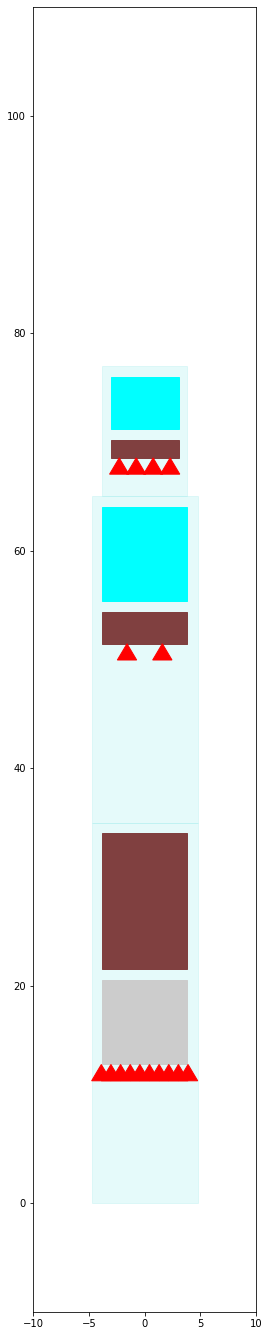

In [14]:
sample = Rocket("Sample Rocket")
sample.add_core(CS1)
sample.add_core(CS2)
sample.add_core(CS3)
sample.info()
sample.plot()